### Complejidad - Práctico 4/6 - Generación procedural de terrenos
#### Lautaro Giordano

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import linregress
import noise

En este práctico exploré un par de ideas para generar terreno proceduralmente, es decir, generar superficies o mapas utilizando algoritmos que se sirvan de cosas como autómatas celulares, ruido, fractales, etc. Me acabo de dar cuenta que parte de mi código está en español y parte en inglés, pido perdón pero lo fui haciendo en distintos momentos y no me di cuenta.

### Parte 1: Generación de una cueva con autómatas celulares

La clase cueva representa un rectángulo de celdas, que sólo pueden valer 0 (vacío) o 1 (lleno/pared). La idea es recrear una cueva en 2D que se podría usar como el mapa en un juego. El mapa se genera empezando con una imagen ruidosa, y en cada iteración de la función "paso_suavizar_cueva" se corre un algoritmo donde cada celda representa un autómata celular. Miro a segundos vecinos cuantas celdas son pared. Si son 5 o más, la celda se hace pared. Si son 3 o menos, se convierte en un espacio. Si son 4, queda como estaba. Este paso se repite varias veces para suavizar la cueva y nos queda algo como lo que vemos abajo

In [2]:
class cueva:
    def __init__(self, width, height, prob_pared, prob_cambio, seed=None):
        self.width = width
        self.height = height
        self.prob_pared = prob_pared
        # El default es seed=None que me da una semilla aleatoria.
        self.seed = seed
        np.random.seed(self.seed)
        self.cueva = self.generar_cueva()
        self.bordes = self.calcular_bordes()
        self.p_cambio = prob_cambio
    

    def generar_cueva(self):
        cueva = np.ones((self.height, self.width))

        # Los bordes siempre son unos (paredes).
        for i in range(1, self.height - 1):
            for j in range(1, self.width - 1):
                cueva[i][j] = 1 if np.random.random() < self.prob_pared else 0
        
        return cueva

    
    def calcular_bordes(self):
        bordes = np.zeros((self.height, self.width))
        valor_borde = 1

        for i in range(1, self.height - 1):
            for j in range(1, self.width - 1):
                # Si la celda actual no es una pared, no forma parte del borde
                if self.cueva[i][j] == 0:
                    continue
                # Chequeo si las paredes del rectangulo son parte del borde
                elif i == 0:
                    if self.cueva[i+1][j] == 0:
                        bordes[i][j] = valor_borde
                elif i == self.height - 1:
                    if self.cueva[i-1][j] == 0:
                        bordes[i][j] = valor_borde 
                elif j == 0: 
                    if self.cueva[i][j+1] == 0:
                        bordes[i][j] = valor_borde
                elif j == self.width - 1:
                    if self.cueva[i][j-1] == 0:
                        bordes[i][j] = valor_borde
                
                else:
                    # Miro a primeros vecinos de una celda
                    # Si hay algún vecino que no es una pared, la celda actual es un borde
                    if self.cueva[i+1][j] == 0 or self.cueva[i-1][j] == 0 or self.cueva[i][j+1] == 0 or self.cueva[i][j-1] == 0:
                        bordes[i][j] = valor_borde
        return bordes
       

    def plot_cueva(self, bordes=False):
        combined = self.cueva.copy()
        escala = 1 / 50

        fig, ax = plt.subplots(figsize=(self.width * escala, self.height * escala))

        if bordes:
            self.bordes = self.calcular_bordes()
            combined[self.bordes == 1] = 2  # Pared que es borde

            # Defino el mapa de colores: 0 = blanco, 1 = negro, 2 = rojo
            cmap = mcolors.ListedColormap(['white', 'black', 'red'])

        else:
            cmap = mcolors.ListedColormap(['white', 'black'])

        ax.imshow(combined, cmap=cmap)
        
        ax.axis('off')
        plt.show()

    def plot_borde(self):
        escala = 1 / 50

        fig, ax = plt.subplots(figsize=(self.width * escala, self.height * escala))
        ax.imshow(self.bordes, cmap='Reds')
        ax.axis('off')

        plt.show()

    def paso_suavizar_cueva(self):
        cueva = self.cueva.copy()
        # No miro los bordes
        for i in range(1, self.height - 1):
            for j in range(1, self.width - 1):
                # Miro a primeros vecinos de una celda
                vecindad = cueva[i-1:i+2, j-1:j+2]
                # Si hay más de 5 celdas con pared, pongo una pared (regla del automata).
                # La regla no es totalmente determinista. Probé agregandolé un poco más de aleatoriedad con una probabilidad de que el cambio ocurra.
                if np.sum(vecindad) >= 5 and np.random.rand() < self.p_cambio:
                    self.cueva[i][j] = 1
                # Si hay menos de 3 celdas con pared, pongo un espacio vacío
                elif np.sum(vecindad) <= 3 and np.random.rand() < self.p_cambio:
                    self.cueva[i][j] = 0
                # Si hay 4 celdas con pared, dejo como está


    def suavizar_cueva(self, n_its=5):
        for _ in range(n_its):
            self.paso_suavizar_cueva()

Aquí vemos la imagen inicial, que es ruido.

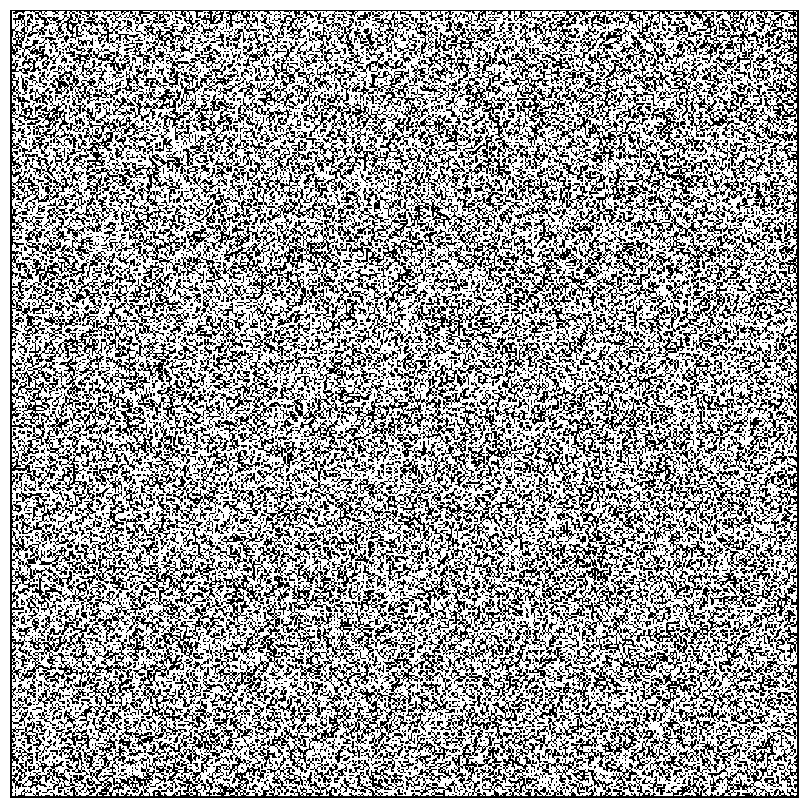

In [4]:
width, height = 512, 512

cuevas = cueva(width, height, prob_pared=0.4, prob_cambio=.7, seed=1)
cuevas.plot_cueva(bordes=False)
cuevas.suavizar_cueva(50)

Y esta es la cueva que se genera. Bastante linda.

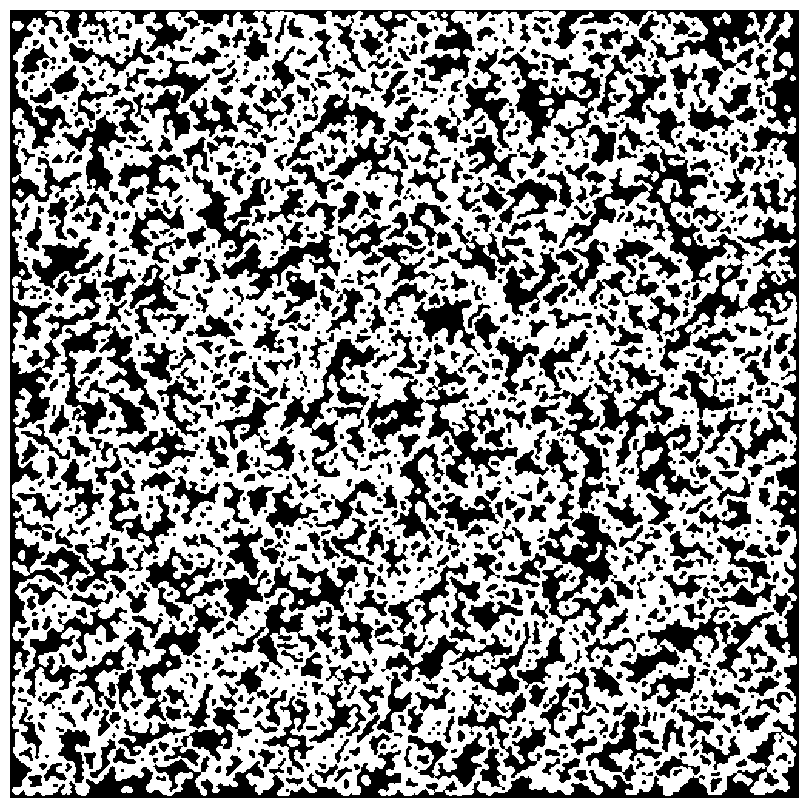

In [5]:
cuevas.plot_cueva()

Qué pasa si miramos los bordes de esta cueva?

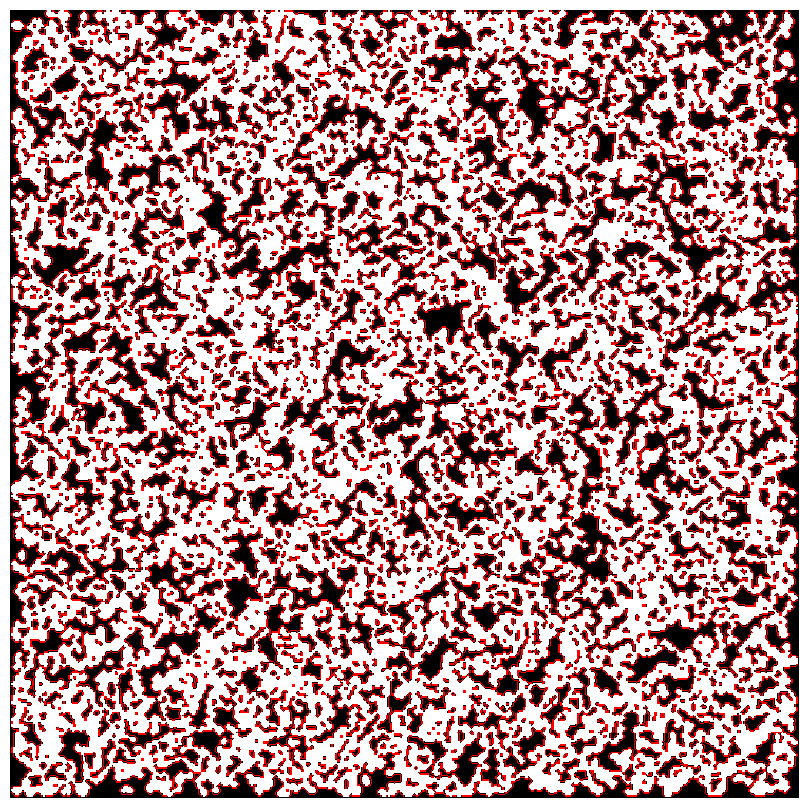

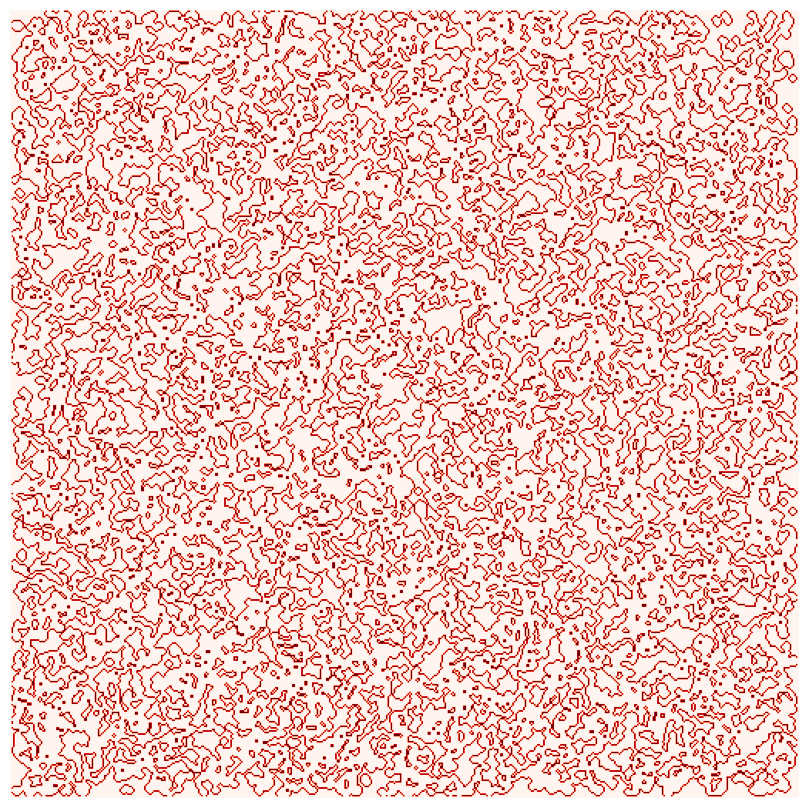

In [6]:
cuevas.plot_cueva(bordes=True)
cuevas.plot_borde()

Es una estructura interesante, será fractal??

Para averiguarlo, voy a calcular la dimensión de box-counting del borde de mi cueva

In [7]:
# Ahora quiero hacer box counting sobre los bordes y estimar su dimension fractal
# Para eso, primero necesito encontrar los bordes de la cueva
# Luego, hago un box counting sobre los bordes
# Finalmente, hago un ajuste lineal para encontrar la dimensión fractal

# Encuentro los bordes de la cueva
bordes = cuevas.calcular_bordes()

Función para hacer box counting

In [8]:
# Hago box counting sobre los bordes
def box_counting(bordes, box_size):
    # Cuento cuántos cuadrados de tamaño box_size necesito para cubrir los bordes
    n_boxes_x = int(np.ceil(bordes.shape[1] / box_size))
    n_boxes_y = int(np.ceil(bordes.shape[0] / box_size))

    boxes = np.zeros((n_boxes_y, n_boxes_x))

    for i in range(n_boxes_y):
        for j in range(n_boxes_x):
            # Cuento cuántos bordes hay en el cuadrado
            box = bordes[i*box_size:(i+1)*box_size, j*box_size:(j+1)*box_size]
            boxes[i, j] = np.sum(box)

    # Devuelvo la cantidad de cuadrados que incluyen al menos un borde
    return np.sum(boxes > 0)

Dimension fractal: 1.96 +- 0.04


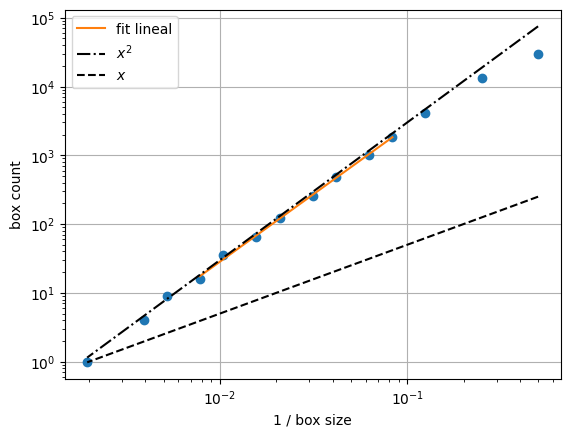

In [13]:
box_sizes = [2, 4, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 512]
inverse_box_sizes = 1 / np.array(box_sizes)
box_counts = [box_counting(bordes, box_size) for box_size in box_sizes]

plt.plot(inverse_box_sizes, box_counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.grid()


# Fiteo solo una zona
sliced_inverse_size = inverse_box_sizes[3:-3]
sliced_box_count = box_counts[3:-3]

slope, intercept, _, _, std_err = linregress(np.log(sliced_inverse_size), np.log(sliced_box_count))
plt.plot(sliced_inverse_size, np.exp(intercept) * sliced_inverse_size**slope, label=f'fit lineal')

# Ploteo x^2
plt.plot(inverse_box_sizes,3e5 * inverse_box_sizes**2, 'k-.', label=r'$x^2$')
plt.plot(inverse_box_sizes,5e2 * inverse_box_sizes, 'k--', label=r'$x$')

plt.xlabel('1 / box size')
plt.ylabel('box count')
plt.legend()

print(f'Dimension fractal: {slope:.2f} +- {std_err:.2f}')


plt.show()

La dimensión parece ser 2. Entonces no es un fractal, el borde es una superficie? Parecería que sí.
Otra forma de probarlo es ver cómo escala la fracción de píxeles que son borde con el tamaño de la imagen. Si la fracción es constante, entonces no es fractal.

In [15]:
proporcion_borde = []

for size in [32, 48, 64, 96, 128, 192, 256]:
    cuevas = cueva(size, size, 0.4, prob_cambio=.7, seed=1)
    cuevas.suavizar_cueva(50)
    borde = cuevas.calcular_bordes()
    proporcion_borde.append(np.sum(borde) / (size * size) * 100)
    print(f"% del borde para cueva de {size}x{size}: {proporcion_borde[-1]:.2f}%")

% del borde para cueva de 32x32: 17.19%
% del borde para cueva de 48x48: 14.50%
% del borde para cueva de 64x64: 16.92%
% del borde para cueva de 96x96: 17.71%
% del borde para cueva de 128x128: 18.11%
% del borde para cueva de 192x192: 18.48%
% del borde para cueva de 256x256: 18.82%


Parece bastante constante :(. Probé algunas cosas más como cambiar las condiciones de contorno, agregar o sacar ruido, cambiar las reglas, pero no conseguí generar un fractal. Mejor probemos con otra cosa.

### Parte 2: Generación de una isla usando Perlin Noise

En esta parte, voy a explorar la generación de la costa de una isla usando ruido. Mi idea es recrear algo como lo que vimos de la costa británica o de Noruega. Mi función va a ser más simple. Voy a generar un mapa de ruido, donde es mucho más probable tener una pared en el centro, y esta probabilidad va decreciendo a medida que me alejo de la isla. Sin embargo, voy a agregar ruido a esta probabilidad para que no sea tan regular. El ruido que voy a utilizar es un ruido muy especial, llamado [Ruido de Perlin](https://en.wikipedia.org/wiki/Perlin_noise), que se usa específicamente para la generación de terrenos y texturas "realistas". Por ejemplo, es el tipo de ruido que está debajo del algoritmo de generación de mundo del Minecraft.

In [16]:
# Create a circular gradient with noise
def generate_island_grid(grid_size, radius, scale=1, peso=.4, octaves=16):
    grid = np.zeros((grid_size, grid_size))
    center_x, center_y = grid_size // 2, grid_size // 2
    for x in range(grid_size):
        for y in range(grid_size):
            # Distancia al centro
            dx = (x - center_x) / radius
            dy = (y - center_y) / radius
            distance = np.sqrt(dx**2 + dy**2)
            
            # Forma base de la isla: La probabiliad de tierra es mayor en el centro
            # Esta parte es determinista. Hay una distancia máxima que depende del radio a partir de la cual
            # land_probability < 0.5 y la celda es agua.
            land_probability = max(0, 1 - distance)
            
            # Agrego Ruido de Perlin a cada celda
            x_scaled, y_scaled = scale * (x / grid_size), scale *  (y / grid_size)
            noise_value = peso * noise.pnoise2(x_scaled, y_scaled, octaves=octaves)

            # La probabilidad de tierra es el valor de base mas un ruido
            final_value = land_probability + noise_value
            
            grid[x, y] = 1 if final_value > 0.5 else 0
    
    return grid

Generemos algunas islas variando los parametros de prueba

La primera, sin ruido, vemos que es un círculo

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_1508\1907778250.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


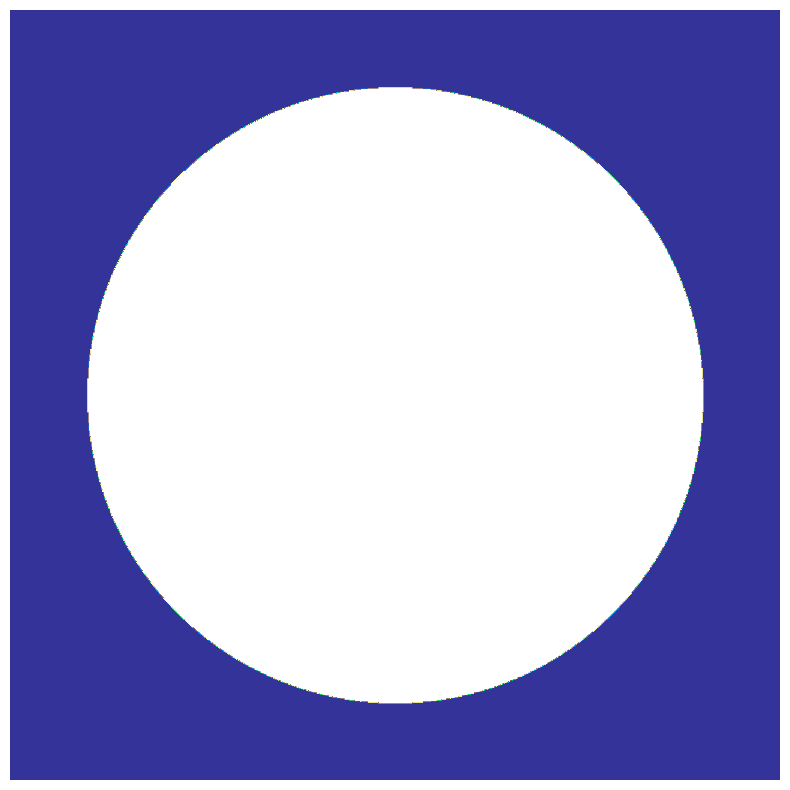

In [17]:
# Generate an island grid and plot
grid_size = 1024
island_grid = generate_island_grid(grid_size, radius=(.8*grid_size), peso=0)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(island_grid, cmap="terrain")
ax.axis('off')
fig.show()

La segunda, agregamos un poco de ruido, pero de muy baja frecuencia. Vemos que la isla es un poco más irregular.

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_1508\3962230161.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


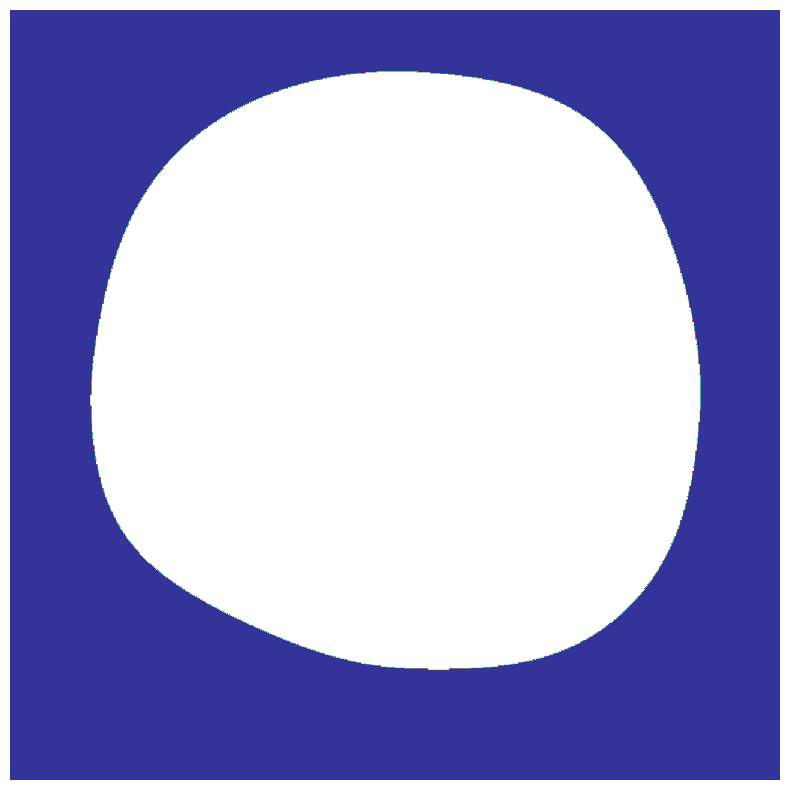

In [18]:
island_grid = generate_island_grid(grid_size, radius=(.8*grid_size), scale=1, peso=.28, octaves=2)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(island_grid, cmap="terrain")
ax.axis('off')
fig.show()

Ahora agregamos el mismo ruido pero a más alta frecuencia. Esto se controla variando el valor de octaves. A más octaves, más "pasadas" de la función de perlin a escalas más chicas.

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_1508\1413701435.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


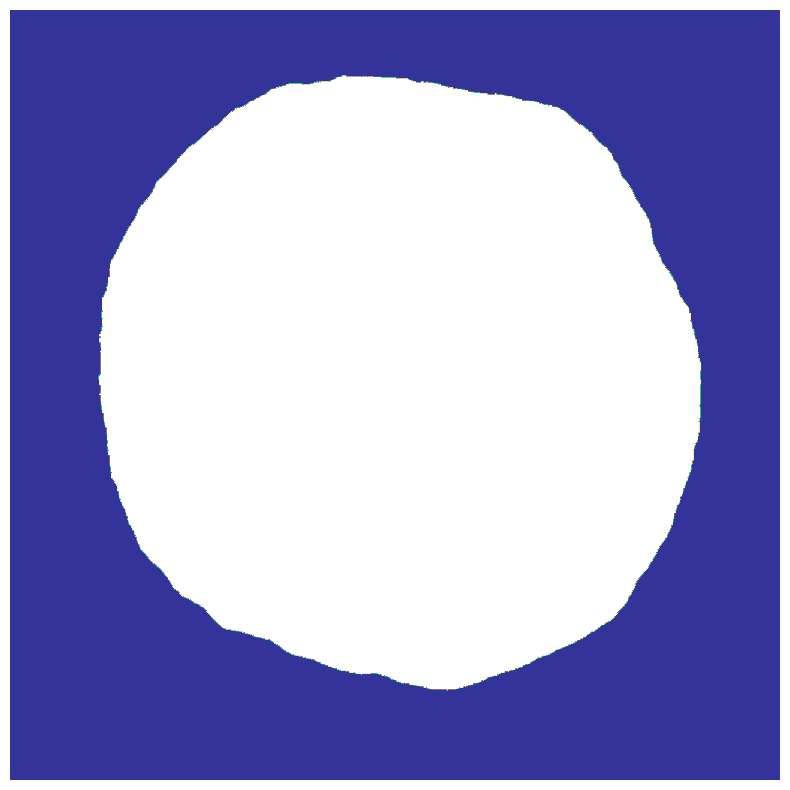

In [19]:
island_grid = generate_island_grid(grid_size, radius=(.8*grid_size), scale=1, peso=.28, octaves=32)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(island_grid, cmap="terrain")
ax.axis('off')
fig.show()

Bueno pero esta isla sigue siendo muy circular. Si cambiamos el valor de la escala, podemos generar islas de formas más irregulares.

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_1508\388348492.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


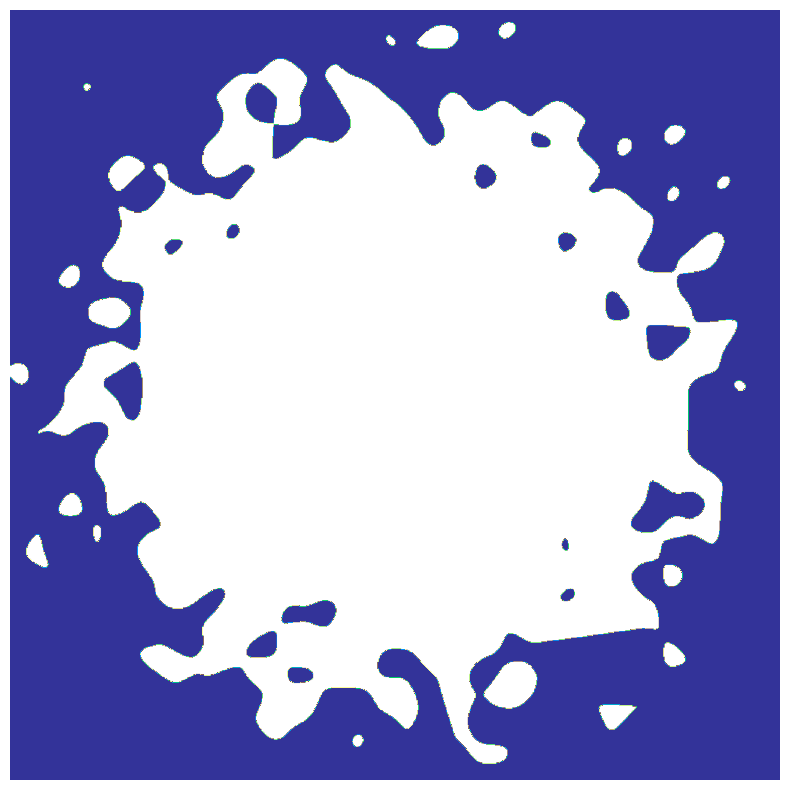

In [20]:
island_grid = generate_island_grid(grid_size, radius=(.8*grid_size), scale=16, peso=.28, octaves=1)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(island_grid, cmap="terrain")
ax.axis('off')
fig.show()

Esta isla se ve más interesante, podemos agregarle más octavas para hacer un borde más irregular.

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_1508\3463930506.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


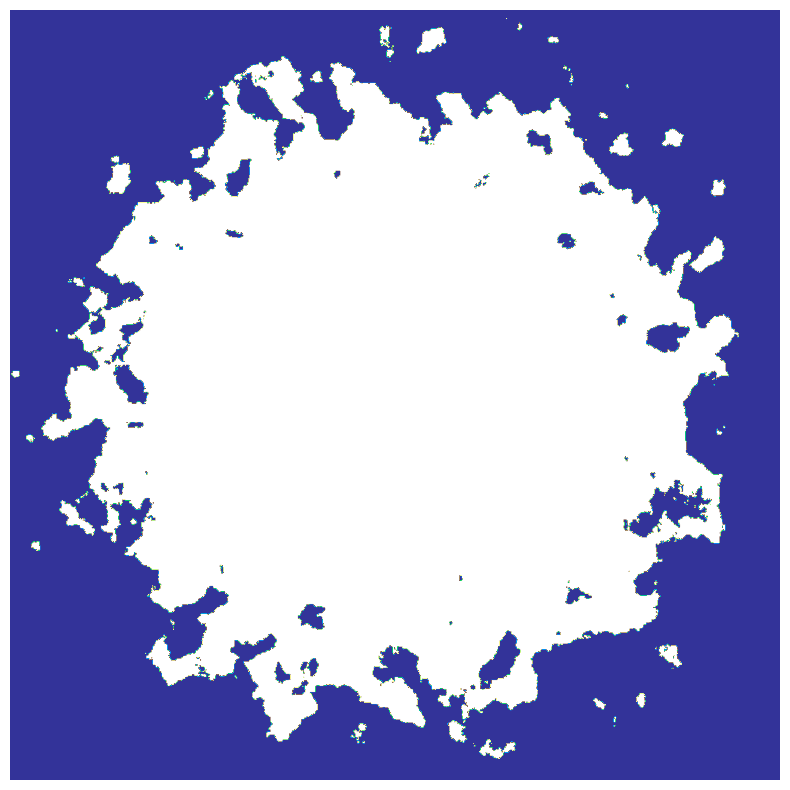

In [21]:
island_grid = generate_island_grid(grid_size, radius=(.8*grid_size), scale=16, peso=.4, octaves=64)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(island_grid, cmap="terrain")
ax.axis('off')
fig.show()

Buenísimo. Será el borde de esta isla un fractal? Se ve bastante lindo de por sí

In [22]:
# Reciclo esta función de más arriba
def calcular_bordes(grid):
        bordes = np.zeros((grid_size, grid_size))
        valor_borde = 1

        for i in range(1, grid_size - 1):
            for j in range(1, grid_size - 1):
                # Si la celda actual no es una pared, no forma parte del borde
                if grid[i][j] == 0:
                    continue
                # Chequeo si las paredes del rectangulo son parte del borde
                elif i == 0:
                    if grid[i+1][j] == 0:
                        bordes[i][j] = valor_borde
                elif i == grid_size - 1:
                    if grid[i-1][j] == 0:
                        bordes[i][j] = valor_borde 
                elif j == 0: 
                    if grid[i][j+1] == 0:
                        bordes[i][j] = valor_borde
                elif j == grid_size - 1:
                    if grid[i][j-1] == 0:
                        bordes[i][j] = valor_borde
                
                else:
                    # Miro a primeros vecinos de una celda
                    # Si hay algún vecino que no es una pared, la celda actual es un borde
                    if grid[i+1][j] == 0 or grid[i-1][j] == 0 or grid[i][j+1] == 0 or grid[i][j-1] == 0:
                        bordes[i][j] = valor_borde
        return bordes

In [23]:
bordes = calcular_bordes(island_grid)

Me gusta mucho como se ven los bordes

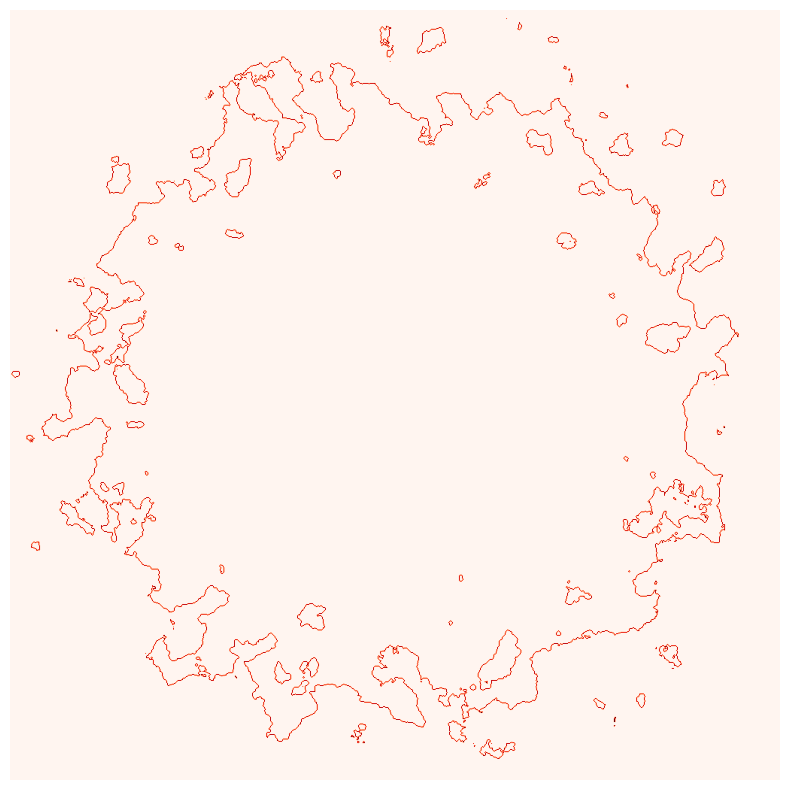

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(bordes, cmap='Reds')
ax.axis('off')
plt.show()

Bueno, momento de la verdad, hagamos box counting.

Dimension fractal: 1.36 +- 0.02


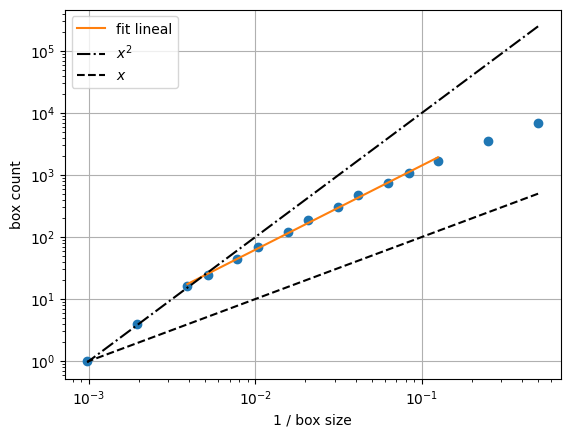

In [25]:
box_sizes = [2, 4, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 512, 1024]
inverse_box_sizes = 1 / np.array(box_sizes)
# bordes[bordes>0]
box_counts = [box_counting(bordes, box_size) for box_size in box_sizes]

plt.plot(inverse_box_sizes, box_counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.grid()

# Fiteo solo una zona
sliced_inverse_size = inverse_box_sizes[2:-2]
sliced_box_count = box_counts[2:-2]

slope, intercept, _, _, std_err = linregress(np.log(sliced_inverse_size), np.log(sliced_box_count))
plt.plot(sliced_inverse_size, np.exp(intercept) * sliced_inverse_size**slope, label=f'fit lineal')

# Ploteo x^2
plt.plot(inverse_box_sizes, 1e6 * inverse_box_sizes**2, 'k-.', label=r'$x^2$')
plt.plot(inverse_box_sizes, 1e3 * inverse_box_sizes, 'k--', label=r'$x$')

plt.xlabel('1 / box size')
plt.ylabel('box count')
plt.legend()

print(f'Dimension fractal: {slope:.2f} +- {std_err:.2f}')


plt.show()

Señoras y señores, parece que tenemos un fractal! La dimensión de box-counting es 1.3, lo que indica que el borde de la isla es un fractal. Qué lindo! Se puede seguir jugando con los parámetros y generar islas de distintas formas y dimensión fractal.